# Ocena jakości wina - projekt zespołowy PRiAD

Zaimportowanie bibliotek oraz wczytanie pliku z danymi

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

wineRed = pd.read_csv('data/winequality-red.csv', sep=";", usecols = range(0,12))
wineWhite = pd.read_csv('data/winequality-white.csv', sep=";", usecols = range(0,12))

### Przedstawienie informacji o zbiorze win czerwonych

Ilość brakujących danych: 0
Ilość obiektów: 1599
Atrybuty: 
	fixed acidity
	volatile acidity
	citric acid
	residual sugar
	chlorides
	free sulfur dioxide
	total sulfur dioxide
	density
	pH
	sulphates
	alcohol
	quality


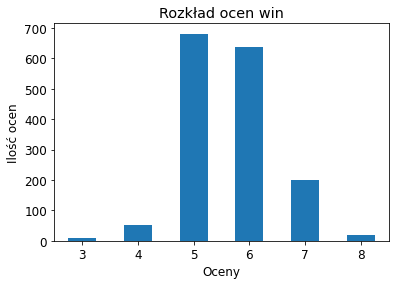

In [235]:
def showGeneralInfo(wine):
    plt.rcParams.update({'font.size': 12})
    missingValues = wine.isnull().sum().sum()
    numberOfObjects = len(wine)
    print("Ilość brakujących danych: " + str(missingValues))
    print("Ilość obiektów: " + str(numberOfObjects))
    df = wine['quality'].value_counts().sort_index(ascending = True)
    df.plot(kind="bar", rot=0, title="Rozkład ocen win", xlabel="Oceny", ylabel="Ilość ocen")
    print("Atrybuty: ")
    for col in wine.columns: 
        print("\t" + col)
    plt.rcParams.update({'font.size': 8})

showGeneralInfo(wineRed)

### Przedstawienie informacji o zbiorze win białych

Ilość brakujących danych: 0
Ilość obiektów: 4898
Atrybuty: 
	fixed acidity
	volatile acidity
	citric acid
	residual sugar
	chlorides
	free sulfur dioxide
	total sulfur dioxide
	density
	pH
	sulphates
	alcohol
	quality


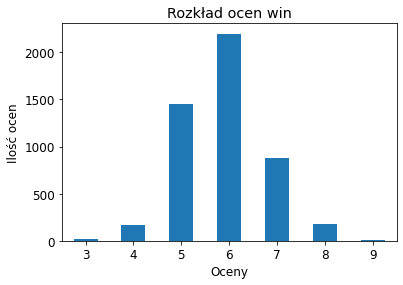

In [236]:
showGeneralInfo(wineWhite)

W obu zbiorach występuje rozkład normalny. Jednakże zbiór win czerwonych charakteryzuje się o wiele mniejszą liczbą obiektów od białego. Dodatkowo w przypadku zbioru białych win, występuje ocena - 'quality' = 9. Dlatego połączenie obu zbiorów może wpłynąć na niekorzyść przyszłych wyników.

### Porównanie win białych i czerwonych

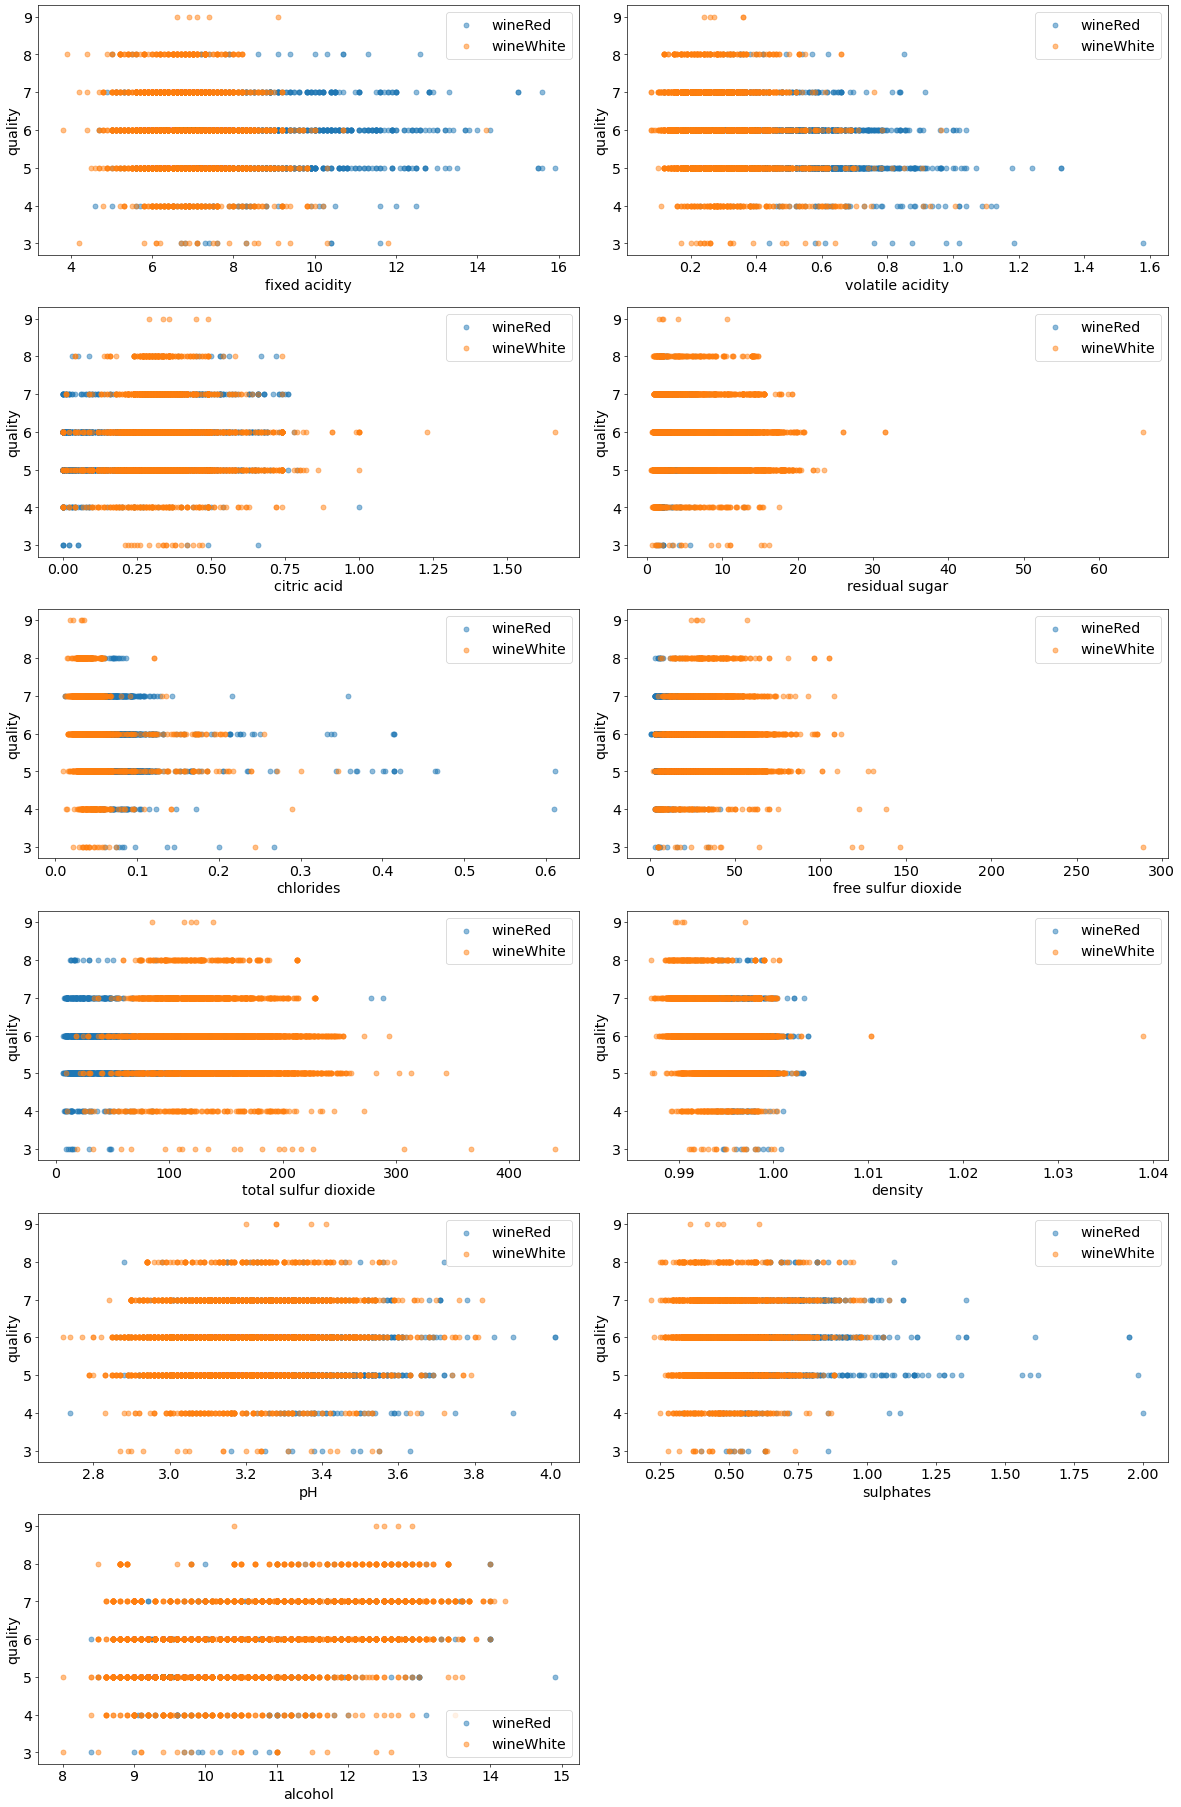

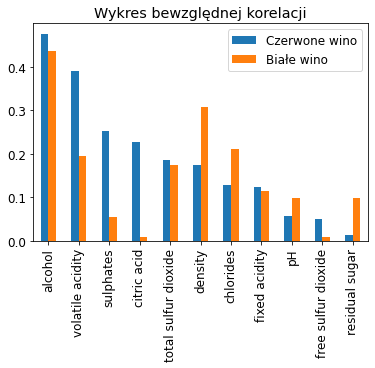

In [228]:
plt.figure(figsize=(20,60), dpi= 75)
def showWinesComparison(wineRed, wineWhite):
    i = 1
    plt.rcParams.update({'font.size': 17})
    for (x) in wineRed.columns:       
        if(x != wineWhite[x].name):
            print ("Kolumny się nie pokrywają")
            return False
        elif (x != 'quality'):
            plt.subplot(12, 2, i)
            plt.scatter(wineRed[x], wineRed['quality'], label = 'wineRed', alpha = 0.5)
            plt.scatter(wineWhite[x], wineWhite['quality'], label = 'wineWhite', alpha = 0.5)
            plt.xlabel(x)
            plt.ylabel('quality')
            plt.tight_layout()
            plt.legend()
            i += 1
            
    plt.rcParams.update({'font.size': 12})    
    correlationsRed = wineRed.corr()['quality']
    correlationsRed = correlationsRed.drop("quality")
    correlationsRed = correlationsRed.abs().sort_values(ascending = False)
    correlationsWhite = wineWhite.corr()['quality']
    correlationsWhite = correlationsWhite.drop("quality")
    correlationsWhite = correlationsWhite.abs().sort_values(ascending = False)
    plotdata = pd.DataFrame({
    "Czerwone wino": correlationsRed,
    "Białe wino": correlationsWhite
    }, index=correlationsRed.index)
    plotdata.plot(kind="bar")
    plt.title("Wykres bewzględnej korelacji")
    plt.rcParams.update({'font.size': 8})

showWinesComparison(wineRed, wineWhite)

Jako, że intersuje nas jakość, porównaliśmy atrybuty dla obu gatunków win wobec jakości. Po analizie zależności można zauważyć, że wiele danych nie pokrywa się ze sobą. Oznacza to, że konkretne wina posiadają unikalne cechy, które wpływają na jakość. Podobnie można odczytać z wykresu korelacji. Dla czerwonych win bardziej znaczący jest np. atrybut "citric acid", gdzie dla białych win ten atrybut jest praktycznie nieznaczący, małowartościowy. Z drugiej strony dla białego wina znaczącym atrybutem jest "density", gdzie w czerwonym winie posiada o wiele mniejszy wpływ na jakość. Dlatego należy rozpatrywać gatunki win jako osobne zbiory danych.

# Badanie dla zbioru "Red Wine"

### Analiza eksporacyjna

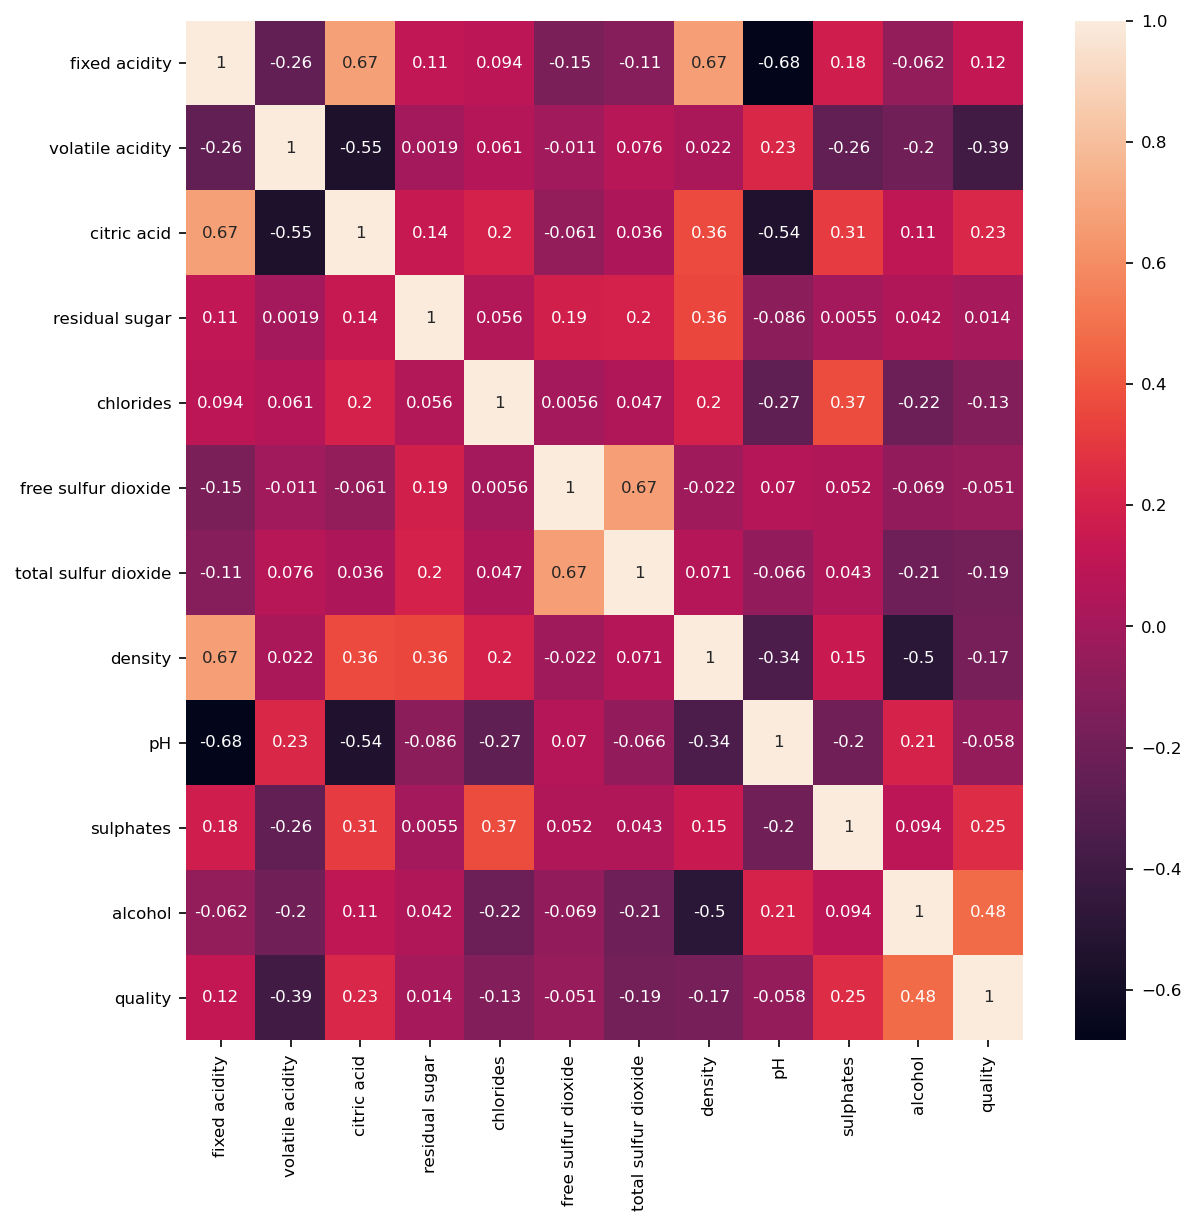

In [216]:
def showCorrelation(wine):
    plt.figure(figsize=(9,9), dpi= 150)
    sns.heatmap(wine.corr(), annot = wine.corr());

showCorrelation(wineRed)

Atrybuty o największym wpływie na jakość wina według kolejności:
	1 - Alcohol
	2 - Volatile acidity
	3 - Sulphates
	4 - Citric acid
	5 - Total sulfur dioxide
	6 - Density
	7 - Chlorides
	8 - Fixed acidity
	9 - Ph
	10 - Free sulfur dioxide


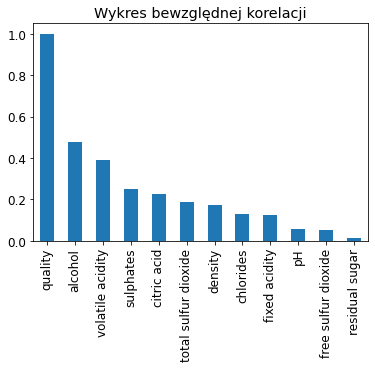

In [232]:
def printCorrelations(wine):
    plt.rcParams.update({'font.size': 12})
    correlations = wine.corr()['quality']
    correlations = correlations.abs().sort_values(ascending = False)
    correlations.plot(kind = 'bar', title = 'Wykres bewzględnej korelacji')
    print("Atrybuty o największym wpływie na jakość wina według kolejności:")
    for x in range(1, 11):
        if(x < 5):
            print(Fore.RED + "\t" + str(x) + " - " + correlations.index[x].capitalize())
        else:
            print(Fore.BLACK + "\t" + str(x) + " - " + correlations.index[x].capitalize())
    plt.rcParams.update({'font.size': 8})

printCorrelations(wineRed)

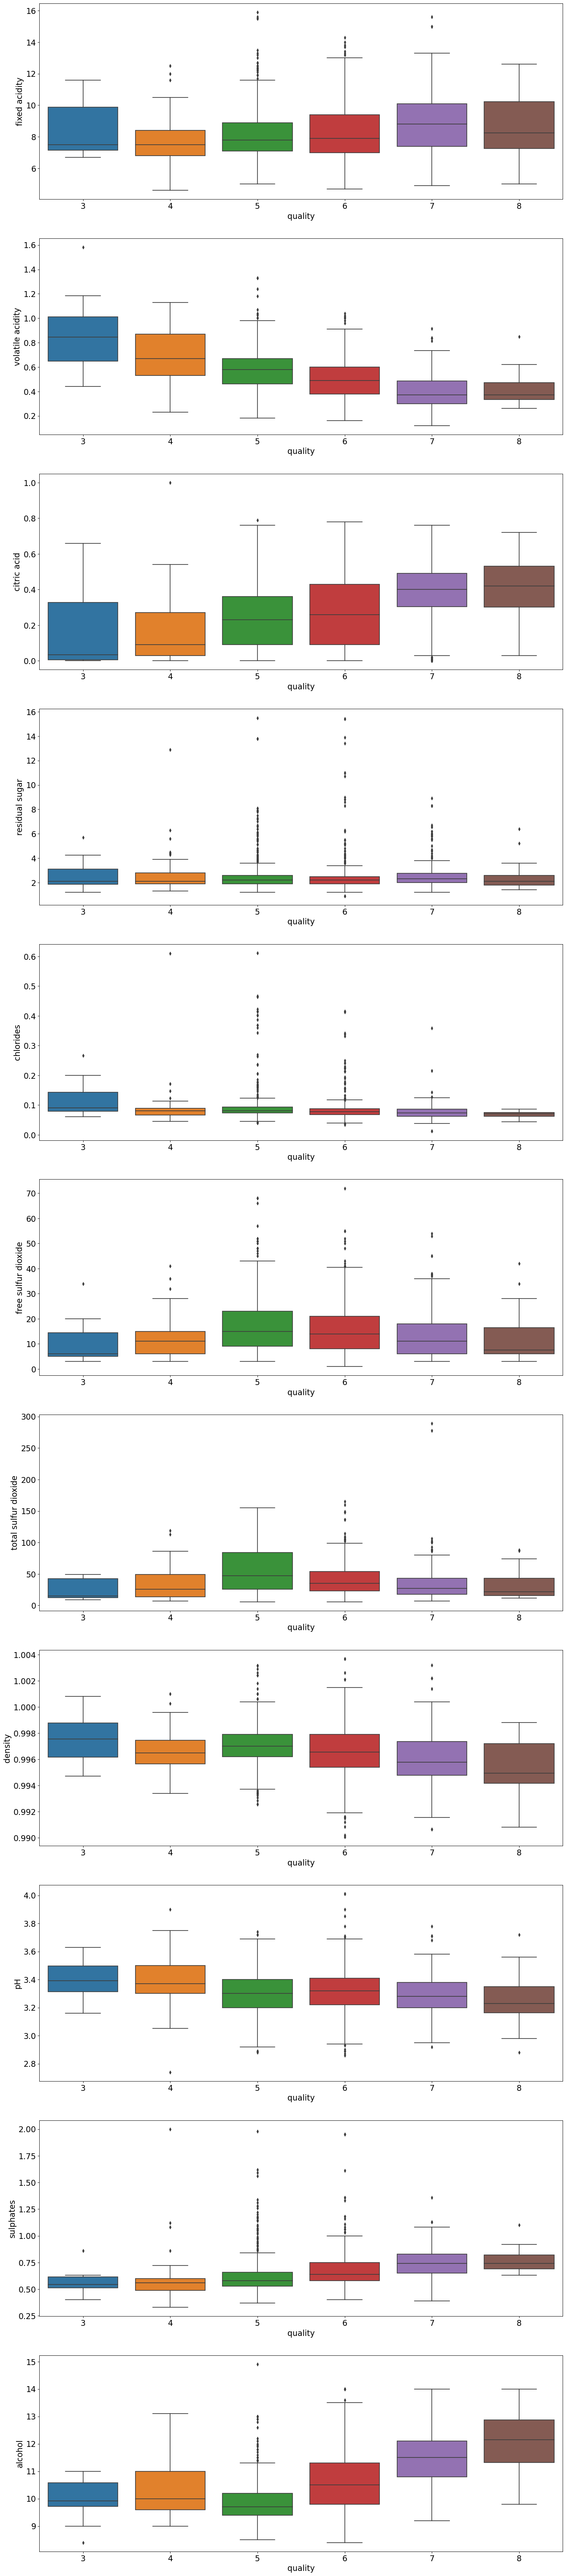

In [237]:
def showBoxPlot(wine):
    plt.rcParams.update({'font.size': 17})
    y = 1
    plt.figure(figsize=(20,100), dpi= 80)
    for atribute in wine.columns:
        if(atribute=="quality"):
            continue
        plt.subplot(11,1,y)
        sns.boxplot(x="quality", y=atribute, data=wine)
        y+=1
    plt.rcParams.update({'font.size': 8})
    
showBoxPlot(wineRed)    

Po wykresach pudełkowych i po macierzy korelacji można zauważyć pewne zależności:

1. Na jakość wina pozytywnie wpływa wzrost alkoholu (alcohol), siarczanów (sulphates) i kwasu cytrynowego (citric acid). Im wyższy jest współczynnik tych atrybutów tym więcej win jest ocenianych pozytywnie. 

Dla alkoholu powyżej 12 % większość win jest oceniana na ocenę 8, która jest najwyższą oceną występującą w naszym zbiorze. 
Dla siarczanów jest to poziom około 0.75 gdzie wina dostają wyższe oceny ( częściowo 6, większość 7-8 ).
Dla kwasu cytrynowego od poziomu 0.4 również oceny win głównie zostają na poziomie 7-8.

2. Negatywnie natomiast na jakość wina wpływają głównie: gęstość (density), pH oraz lotna kwasowość (volatile acidity).

W gęstości różnice są minimalne ale nie zerowe i można zauważyć na wykresie że wina wyżej oceniane mają gęstość znakomo mniejszą.
W pH podobnie jak w gęstości różnice również nie są duże jednak ilość pH w winach lepiej ocenianych jest mniejsza.
W lotnej kwasowości ta różnica jest bardziej widoczna gdyż widać że wina z ocenami 7 i 8 znacząco odstają od reszty ocen w przypadku zmniejszenia wartości tego atrybutu (tą zależność widać również obserwując wysoką korelację z oceną)

Jednak po zauważeniu, że korelacja między kwasem cytrynowym, a lotną kwasowością jest wysoka (-0.55) możemy wykluczyć kwas cytrynowy z dalszej analizy. To samo możemy zrobić z gęstością która ma wysoką korelację (-0.5) z alkoholem.

Inne atrybuty o wysokiej korelacji to:
- pH i fixed acidity
- citric acid i pH
- citric acid i fixed acidity
- fixed acidity i density

Pozostałe atrybuty nie wykazują znaczącego wpływu na ocenę jakości wina.

### Regresja liniowa dla wybranych atrybutów


Porównanie kilku modeli regresji
                      LinearRegression  LassoRegression
learning_error RMSE          0.436628         0.525310
general_error RMSE           0.394410         0.436511
MAE error                    0.475331         0.521903


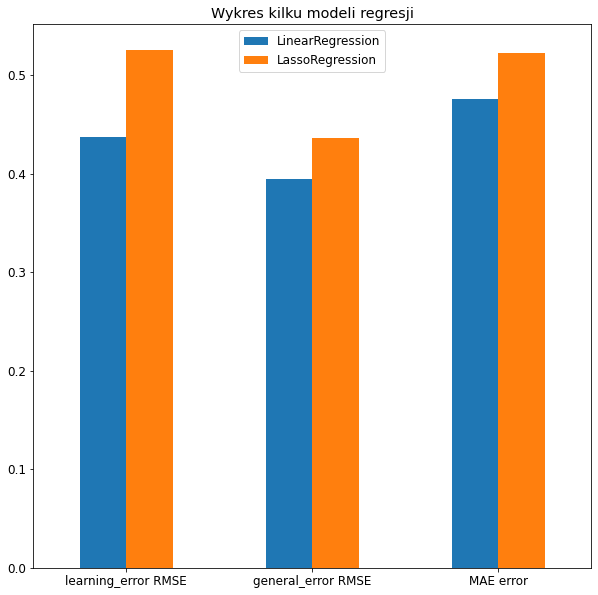

In [230]:
def createRegressionModel(wine,xValues):
    plt.rcParams.update({'font.size': 12})
    regressor = LinearRegression()
    x = wine[xValues]
    y = wine['quality']

    x_ucz, x_test, y_ucz, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    #Wybranie kilku modelu regresji i wpisanie do hashMapy
    regressors = {}
    regressors['LinearRegression'] = LinearRegression()
    regressors['LassoRegression'] = Lasso(alpha=0.1) # alpha > 0

    #Stworzenie hashMapy zbierającą dane o jakości dobrania
    check_fit = {}

    for type in regressors:
        this_regressor = regressors[type]
        this_regressor.fit(x_ucz,y_ucz) 

        y_pred_ucz = this_regressor.predict(x_ucz)
        e_ucz = metrics.mean_squared_error(y_ucz, y_pred_ucz)
        y_pred_test = this_regressor.predict(x_test)
        e_test = metrics.mean_squared_error(y_test, y_pred_test)
        MAE = metrics.mean_absolute_error(y_test,y_pred_test)
        check_fit[type] = {"learning_error RMSE" : e_ucz, "general_error RMSE" : e_test, "MAE error":MAE}    

    #Rysowanie wykresu porównującego błędy
    df_for_comparison = pd.DataFrame(check_fit)
    df_for_comparison.plot.bar(rot=0, figsize=(10,10), title = "Wykres kilku modeli regresji")

    print("\nPorównanie kilku modeli regresji\n", df_for_comparison)
    plt.rcParams.update({'font.size': 8})
   
xValues = ['alcohol','sulphates','volatile acidity','total sulfur dioxide']
createRegressionModel(wineRed,xValues)

Jako że metoda Liniowej Regresji ma mniejsze błędy w obu metodach będzie ona odpowiedniejszym modelem w ocenie jakości wina.

# Badanie dla zbioru "White Wine"

### Analiza eksporacyjna

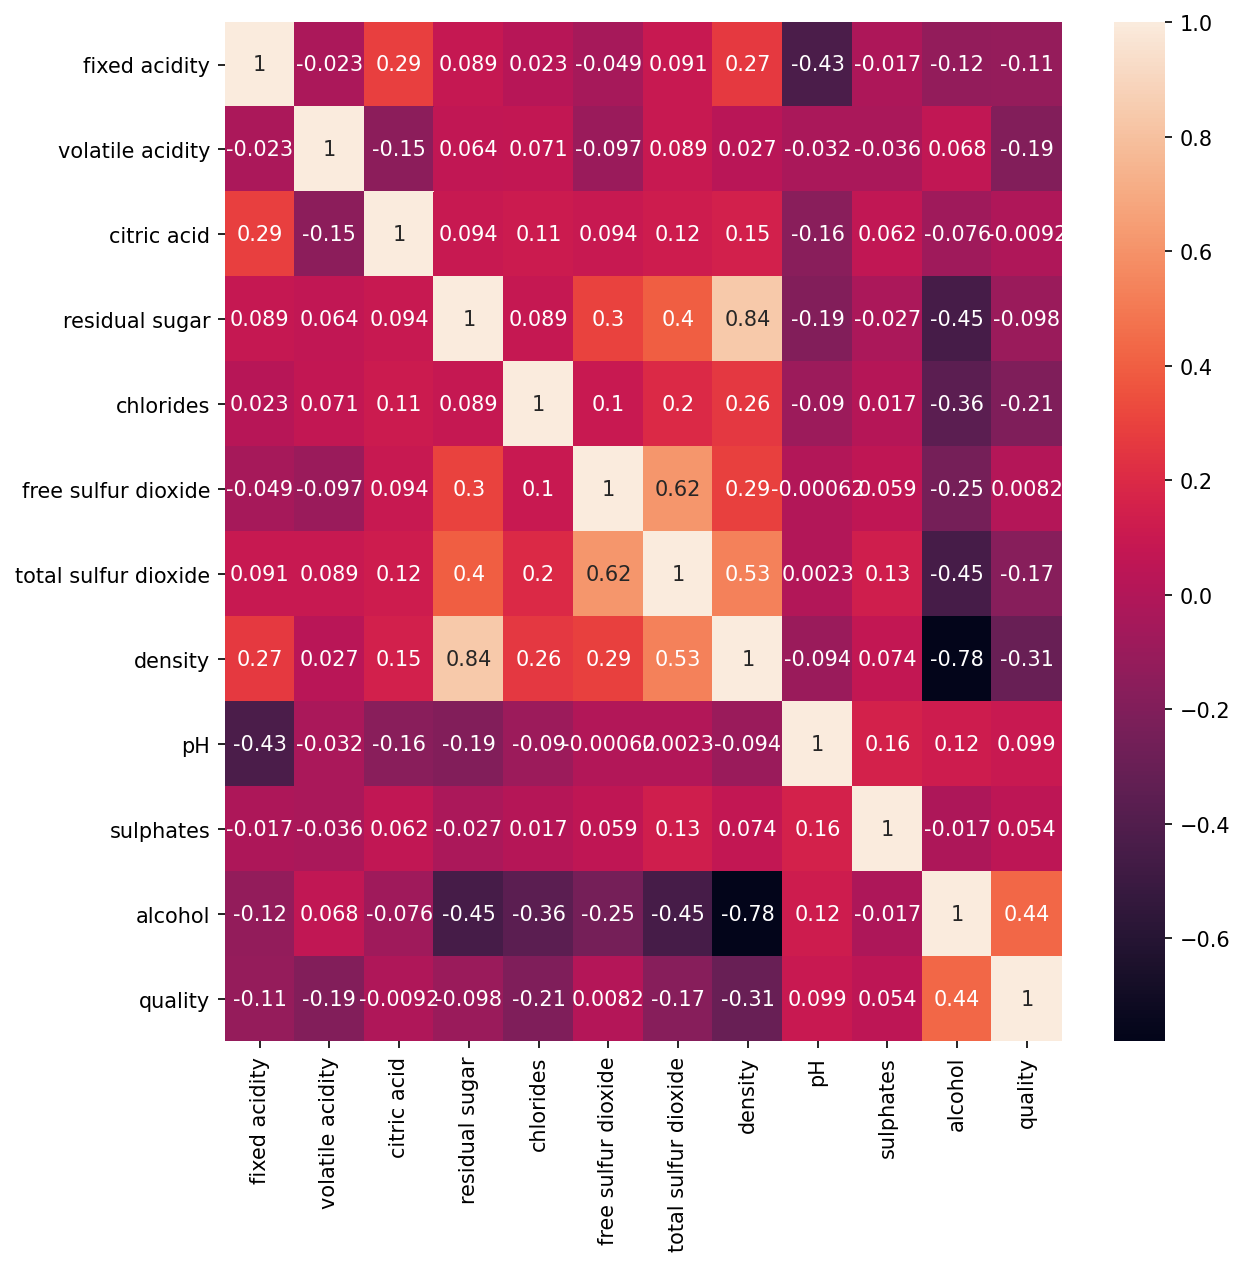

In [183]:
showCorrelation(wineWhite)

Atrybuty o największym wpływie na jakość wina według kolejności:
	1 - Alcohol
	2 - Density
	3 - Chlorides
	4 - Volatile acidity
	5 - Total sulfur dioxide
	6 - Fixed acidity
	7 - Ph
	8 - Residual sugar
	9 - Sulphates
	10 - Citric acid


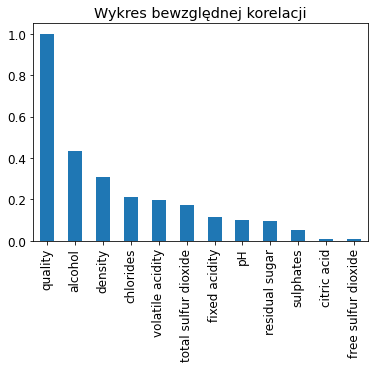

In [233]:
printCorrelations(wineWhite)

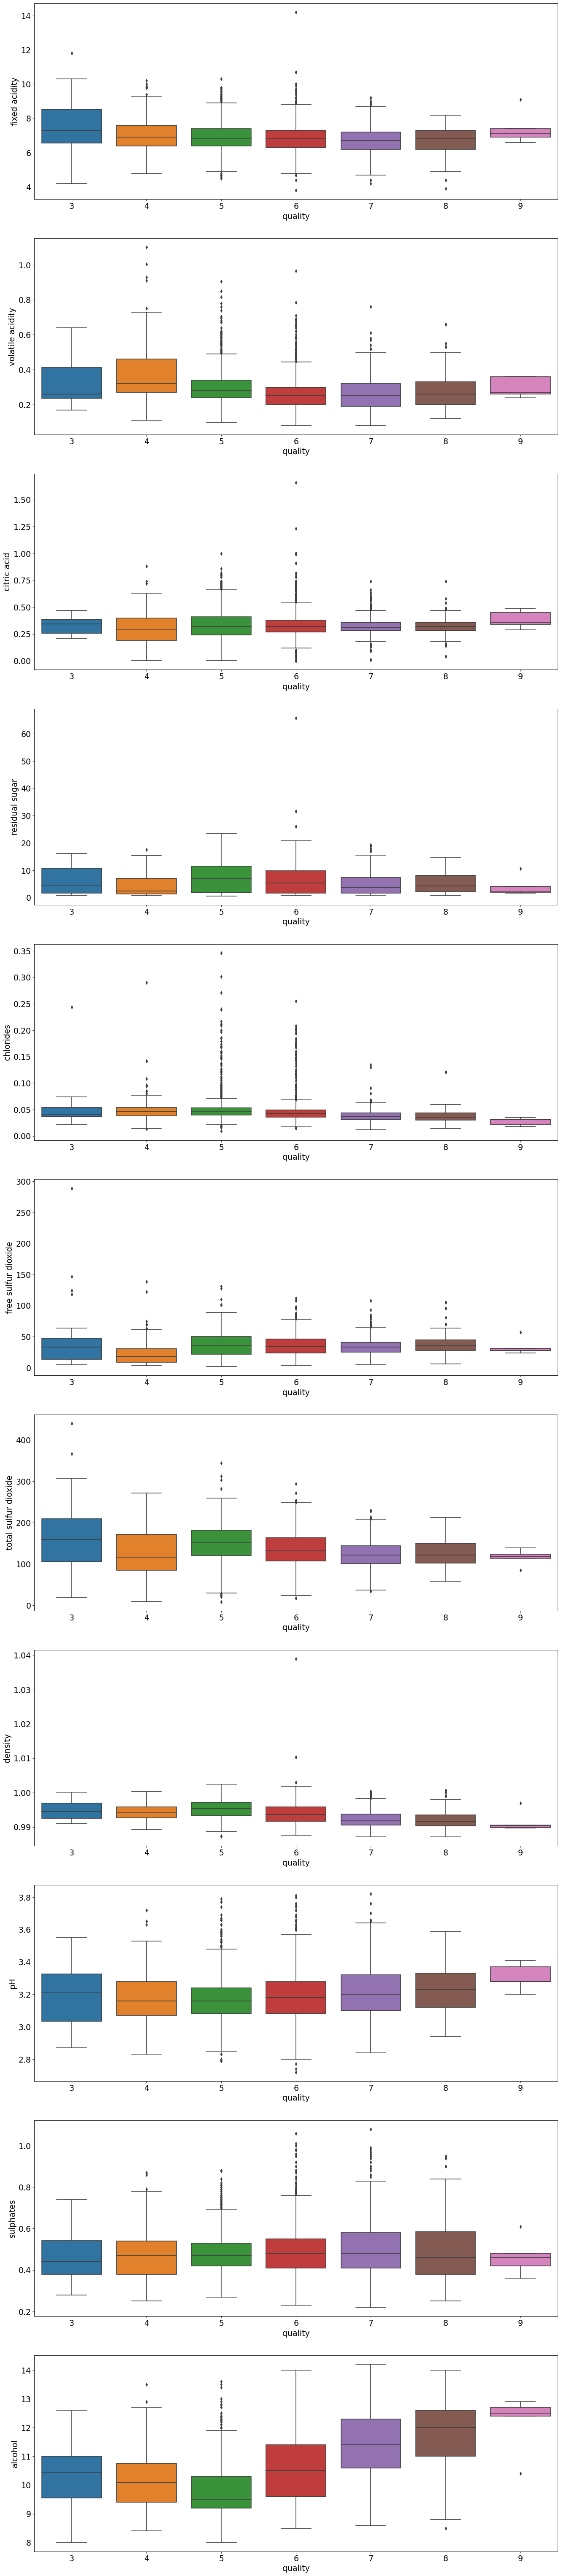

In [238]:
showBoxPlot(wineWhite)

Podobnie jak w przypadku win czerwonych, atrybutem najbardziej wpływowy na jakość wina jest poziom alkoholu.
Na jakość win białych pozytywnie wypływa znacząco jedynie poziom alkoholu (alkohol). Negatywnie zaś wpływają:
- Gęstość (density)
- Chlorki (chlorides)
- Kwasowość lotna vVolatile acidity)
- Całkowity poziom dwutlenku siarki (total sulfur dioxide)
Pozostałe atrybuty nieznacznie wpływają na jakość wina.
Pozostałe atrybuty nieznacznie wpływają na jakość białego wina.

Po zauważeniu, że korelacja między gęstością, a poziomem alkoholu jest wysoka (-0.78) możemy wykluczyć gęstość z dalszej analizy.

### Regresja liniowa dla wybranych atrybutów


Porównanie kilku modeli regresji
                      LinearRegression  LassoRegression
learning_error RMSE          0.566562         0.618386
general_error RMSE           0.684867         0.739569
MAE error                    0.647524         0.673399


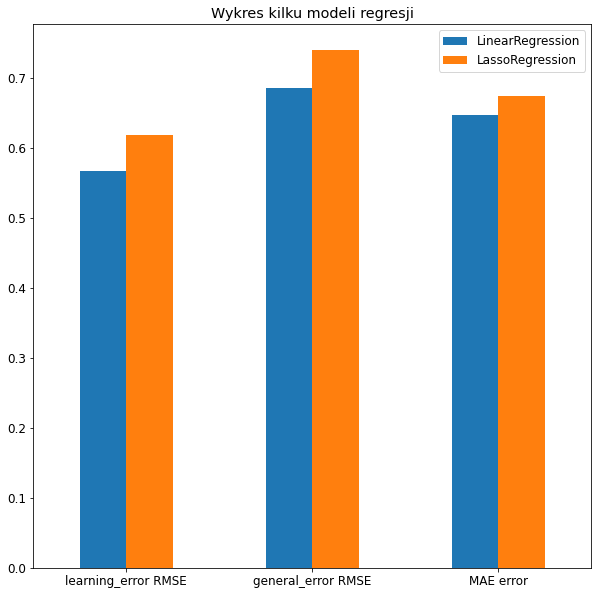

In [234]:
xValues = ['alcohol','chlorides','volatile acidity']
createRegressionModel(wineWhite,xValues)

Jako że metoda Liniowej Regresji ma mniejsze błędy w obu metodach będzie ona odpowiedniejszym modelem w ocenie jakości wina.